### **Music_Genre_Classification_Using_Fully_Connected_NN**<br>

Team Members:

*   Francis, Rikky Linuz - UTA ID: 1001753137
*   Mukka, Himaneesh - UTA ID: 1001861524
*   Smitherman, Samuel M - UTA ID: 1000762170

Link of the google colab: https://colab.research.google.com/drive/1mipbK1I5VGm0dgjpWUl9eXaqUhWtJjTG?usp=sharing

In [2]:
import json
import os
import math
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings
# import tensorflow as tf
from keras.utils.np_utils import to_categorical 
from sklearn.metrics import classification_report  

from sklearn.preprocessing import StandardScaler

from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# 1. Evaluate Fully Connected Neural Network using Mel-Spectrograms

## On GTZAN dataset

### Creating 1 segment of Mel Specs on each audio 

#### Code to prepare Mel-Spectrograms using single segment and pcen normalization for GTZAN dataset

In [ ]:
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"

In [ ]:
## Method to save GTZAN Melspectrogram 
## hop_length=512
def save_mels_single_segment_gtzan(dataset_path, n_mels=128, n_fft=2048, hop_length=512):

    X_spect = np.empty((0, 640, 128))
    m_specs = []
    genres = []
    count = 0

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:
                count+=1
		            # load audio file
                file_path = os.path.join(dirpath, f)
                y, sr = librosa.load(file_path)

                # extract melspect
                mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                mels = librosa.core.pcen(mels, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
                mels = mels.T

                # Normalize for small shape differences
                mels = mels[:640, :]

                X_spect = np.append(X_spect, [mels], axis=0)
                genres.append(i-1)
                print("Currently Processing: ",count)
          
    y_arr = np.array(genres)
    return X_spect, y_arr

In [ ]:
X_whole, y_whole = save_mels_single_segment_gtzan(DATASET_PATH)


Processing: country
Currently Processing:  1
Currently Processing:  2
Currently Processing:  3
Currently Processing:  4
Currently Processing:  5
Currently Processing:  6
Currently Processing:  7
Currently Processing:  8
Currently Processing:  9
Currently Processing:  10
Currently Processing:  11
Currently Processing:  12
Currently Processing:  13
Currently Processing:  14
Currently Processing:  15
Currently Processing:  16
Currently Processing:  17
Currently Processing:  18
Currently Processing:  19
Currently Processing:  20
Currently Processing:  21
Currently Processing:  22
Currently Processing:  23
Currently Processing:  24
Currently Processing:  25
Currently Processing:  26
Currently Processing:  27
Currently Processing:  28
Currently Processing:  29
Currently Processing:  30
Currently Processing:  31
Currently Processing:  32
Currently Processing:  33
Currently Processing:  34
Currently Processing:  35
Currently Processing:  36
Currently Processing:  37
Currently Processing:  38


In [ ]:
print(X_whole.shape)
print(y_whole.shape)

(1000, 640, 128)
(1000,)


In [ ]:
np.save("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole.npy", X_whole)
np.save("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole.npy", y_whole)

#### Load the Mel-Spectrograms created above with 1 segment, build, train and evaluate the model

In [ ]:
X_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole_1s.npy")
y_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole_1s.npy")

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X_whole, y_whole, random_state=42, stratify=y_whole, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
X_train.shape

(600, 640, 128)

In [ ]:
X_validation.shape

(200, 640, 128)

In [ ]:
X_test.shape

(200, 640, 128)

In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add 4 Dense layers
    model.add(keras.layers.Dense(128,  activation='relu', kernel_initializer='glorot_uniform', input_shape=input_shape))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(64,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(32,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(16,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
gtzan_mels_model1 = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.0005)
gtzan_mels_model1.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mels_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 640, 128)          16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 640, 128)          0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 640, 128)          512       
_________________________________________________________________
dense_11 (Dense)             (None, 640, 64)           8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 640, 64)           0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 640, 64)           256       
_________________________________________________________________
dense_12 (Dense)             (None, 640, 32)          

In [ ]:
gtzan_mels_history1 = gtzan_mels_model1.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=1,
                                          batch_size=32, epochs=50 )

Epoch 1/50
19/19 [==============================] - 3s 34ms/step - loss: 2.8641 - accuracy: 0.1017 - val_loss: 2.3136 - val_accuracy: 0.1000
Epoch 2/50
19/19 [==============================] - 0s 16ms/step - loss: 2.3804 - accuracy: 0.1675 - val_loss: 2.6093 - val_accuracy: 0.1000
Epoch 3/50
19/19 [==============================] - 0s 15ms/step - loss: 2.2245 - accuracy: 0.2457 - val_loss: 3.2057 - val_accuracy: 0.1000
Epoch 4/50
19/19 [==============================] - 0s 15ms/step - loss: 1.9718 - accuracy: 0.2953 - val_loss: 3.2405 - val_accuracy: 0.1000
Epoch 5/50
19/19 [==============================] - 0s 15ms/step - loss: 1.8928 - accuracy: 0.3320 - val_loss: 3.4230 - val_accuracy: 0.1000
Epoch 6/50
19/19 [==============================] - 0s 15ms/step - loss: 1.8396 - accuracy: 0.3397 - val_loss: 3.3463 - val_accuracy: 0.1000
Epoch 7/50
19/19 [==============================] - 0s 15ms/step - loss: 1.7395 - accuracy: 0.3983 - val_loss: 3.4596 - val_accuracy: 0.1000
Epoch 8/50
19

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


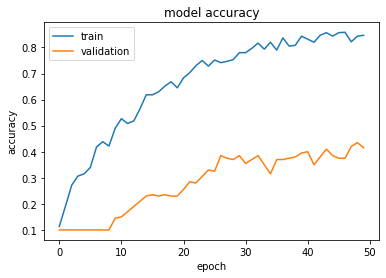

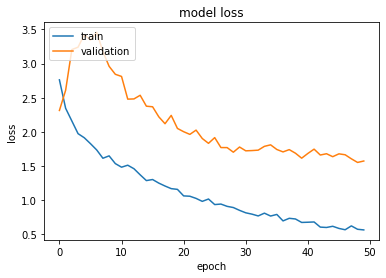

In [ ]:
show_summary_stats(gtzan_mels_history1)

In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mels_model1.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

7/7 - 0s - loss: 1.5772 - accuracy: 0.4650

Test accuracy: 0.4650000035762787


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mels_model1.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(200,) (200,)
              precision    recall  f1-score   support

       blues       0.27      0.15      0.19        20
   classical       0.43      0.95      0.59        20
     country       0.38      0.25      0.30        20
       disco       0.19      0.40      0.26        20
      hiphop       0.43      0.15      0.22        20
        jazz       1.00      0.35      0.52        20
       metal       0.76      0.80      0.78        20
         pop       0.88      0.35      0.50        20
      reggae       0.36      0.20      0.26        20
        rock       0.31      0.55      0.39        20

    accuracy                           0.41       200
   macro avg       0.50      0.42      0.40       200
weighted avg       0.50      0.41      0.40       200



### Creating 5 segments of Mel Specs on each audio



#### Code to prepare Mel-Spectrograms using 5 segments and pcen normalization for GTZAN dataset

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"
JSON_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-mels.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512
def save_mels_gtzan(dataset_path, json_path, n_mels=128, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mels": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mels_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                y, sr = librosa.load(file_path)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mels = librosa.feature.melspectrogram(y[start:finish], sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
                    mels = librosa.core.pcen(mels, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
                    mels = mels.T

                    # store only mfcc feature with expected number of vectors
                    if len(mels) == num_mels_vectors_per_segment:
                        data["mels"].append(mels.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))


    # save MFCCs to json file
    # with open(json_path, "w") as fp:
    #     json.dump(data, fp, indent=4)

    return data["mels"], data["labels"]

In [ ]:
now = datetime.now()
X_whole, y_whole = save_mels_gtzan(DATASET_PATH,JSON_PATH)
print("Time taken: ", (datetime.now() - now).total_seconds())

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00002.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00007.wav, segment:1
/

#### Load the Mel-Spectrograms created above with 5 segments, build, train and evaluate the model

In [ ]:
X_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_X_whole_5s.npy")
y_whole=np.load("gdrive/MyDrive/gtzan_genres_data/gtzan_y_whole_5s.npy")

In [ ]:
X_whole.shape

(4998, 259, 128)

In [ ]:
y_whole.shape

(4998,)

In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X_whole, y_whole, random_state=42, stratify=y_whole, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
X_train.shape

(2811, 259, 128)

In [ ]:
X_validation.shape

(937, 259, 128)

In [ ]:
X_test.shape

(1250, 259, 128)

In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add 4 Dense layers
    model.add(keras.layers.Dense(256,  activation='relu', kernel_initializer='glorot_uniform', input_shape=input_shape))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(128,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(64,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(16,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
gtzan_mels_model = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.00075)
gtzan_mels_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mels_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 259, 256)          33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 259, 256)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 259, 256)          1024      
_________________________________________________________________
dense_16 (Dense)             (None, 259, 128)          32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 259, 128)          0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 259, 128)          512       
_________________________________________________________________
dense_17 (Dense)             (None, 259, 64)          

In [ ]:
gtzan_mels_history = gtzan_mels_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=1,
                                          batch_size=128, epochs=75 )

Epoch 1/75
22/22 [==============================] - 3s 41ms/step - loss: 2.5866 - accuracy: 0.1633 - val_loss: 2.1390 - val_accuracy: 0.1964
Epoch 2/75
22/22 [==============================] - 1s 25ms/step - loss: 2.0532 - accuracy: 0.2970 - val_loss: 2.2711 - val_accuracy: 0.2263
Epoch 3/75
22/22 [==============================] - 1s 25ms/step - loss: 1.8566 - accuracy: 0.3601 - val_loss: 2.6675 - val_accuracy: 0.2263
Epoch 4/75
22/22 [==============================] - 1s 25ms/step - loss: 1.6982 - accuracy: 0.4158 - val_loss: 2.6613 - val_accuracy: 0.2188
Epoch 5/75
22/22 [==============================] - 1s 25ms/step - loss: 1.5900 - accuracy: 0.4548 - val_loss: 2.7981 - val_accuracy: 0.2284
Epoch 6/75
22/22 [==============================] - 1s 25ms/step - loss: 1.5283 - accuracy: 0.4774 - val_loss: 2.7237 - val_accuracy: 0.2327
Epoch 7/75
22/22 [==============================] - 1s 25ms/step - loss: 1.4319 - accuracy: 0.5084 - val_loss: 2.7606 - val_accuracy: 0.1857
Epoch 8/75
22

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


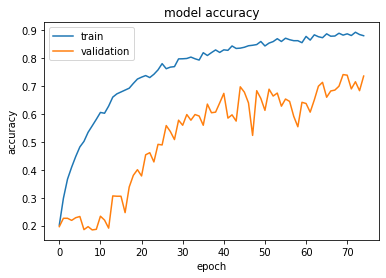

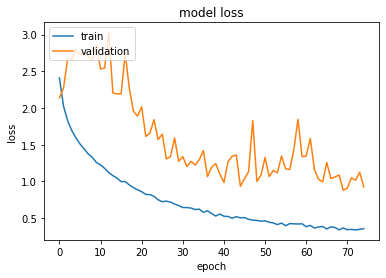

In [ ]:
show_summary_stats(gtzan_mels_history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mels_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

40/40 - 0s - loss: 0.9046 - accuracy: 0.7304

Test accuracy: 0.730400025844574


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mels_model.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(937,) (937,)
              precision    recall  f1-score   support

       blues       0.70      0.66      0.68        94
   classical       0.87      0.98      0.92        94
     country       0.56      0.76      0.65        93
       disco       0.78      0.31      0.44        94
      hiphop       0.89      0.68      0.77        93
        jazz       0.85      0.91      0.88        94
       metal       0.81      0.91      0.86        94
         pop       0.73      0.88      0.80        94
      reggae       0.68      0.70      0.69        94
        rock       0.55      0.55      0.55        93

    accuracy                           0.74       937
   macro avg       0.74      0.74      0.72       937
weighted avg       0.74      0.74      0.72       937



## On FMA dataset

### Code to prepare Mel-Spectrograms for FMA dataset

In [ ]:
## Read the tracks details from csv to a dataframe
df = pd.read_csv("/content/gdrive/MyDrive/fma_small/tracks_with_required_columns.csv", index_col=0, header=[0, 1])
df.shape

(8000, 3)

In [ ]:
df.head()

set            track
             split subset genre_top
track_id                           
2         training  small   Hip-Hop
5         training  small   Hip-Hop
10        training  small       Pop
140       training  small      Folk
141       training  small      Folk

In [ ]:
df['track_id'] = df.index
df.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [ ]:
df[('track', 'genre_top')].unique()

array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [ ]:
df_train = df[df[('set', 'split')]=='training']
df_test = df[df[('set', 'split')]=='test']
df_valid = df[df[('set', 'split')]=='validation']

print(df_train.shape, df_valid.shape, df_test.shape)

(6400, 3) (800, 3) (800, 3)


In [ ]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [ ]:
## Method to get a track path given data directory and track_id
def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(int(track_id))
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [ ]:
def create_spectogram(audio_dir, track_id, n_fft, hop_length):
    filepath = get_audio_path(audio_dir, track_id)

    y, sr = librosa.load(filepath)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=n_fft, hop_length=hop_length, n_mels=128)
    spect = librosa.core.pcen(spect, 
                                 sr            = sr,
                                 hop_length    = 512,
                                 gain          = 0.6,
                                 bias          = 0.1,
                                 power         = 0.2,
                                 time_constant = 0.4,
                                 eps           = 1e-9)
    return spect.T

In [ ]:
def create_X_y_data_array(df, audio_dir, n_fft, hop_length):

    genres = []
    X_spect = np.empty((0, 640, 128))
    count = 0
    #Code skips records in case of errors
    for index, row in df.iterrows():
        with warnings.catch_warnings():
            try:
                warnings.simplefilter("ignore")
                count += 1
                track_id = int(row['track_id'])
                genre = str(row[('track', 'genre_top')])
                spect = create_spectogram(audio_dir, track_id, n_fft, hop_length)

                # Normalize for small shape differences
                spect = spect[:640, :]
                X_spect = np.append(X_spect, [spect], axis=0)
                genres.append(genres_dict[genre])
                if count % 100 == 0:
                    print("Currently processing: ", count)
            except Exception as e:
                print(e)
                print("Couldn't process: ", count)
                continue
            # break
    y_arr = np.array(genres)
    return X_spect, y_arr

In [ ]:
FMA_audio_path = "/content/gdrive/MyDrive/fma_small"

In [ ]:
X_test, y_test = create_X_y_data_array(df_test, FMA_audio_path,2048, 512)
print(X_test.shape, y_test.shape)

In [ ]:
np.savez('test_data', X_test, y_test)

In [ ]:
X_valid, y_valid = create_X_y_data_array(df_valid, FMA_audio_path,2048, 512)
print(X_valid.shape, y_valid.shape)

In [ ]:
np.savez('validation_data', X_valid, y_valid)

Splitting the training dataset into 4 smaller size. (As it takes lot of time to process, sometimes session crashes due to RAM limitation.)

In [ ]:
def split_df_into_smaller(df, chunk_size = 1600): 
    list_of_df = list()
    number_of_chunks = len(df) // chunk_size + 1
    for i in range(number_of_chunks):
        list_of_df.append(df[i*chunk_size:(i+1)*chunk_size])
    return list_of_df

In [ ]:
list_df = split_df_into_smaller(df_train)
df1_train = list_df[0]
df2_train = list_df[1]
df3_train = list_df[2]
df4_train = list_df[3]
print(df1_train.shape, df2_train.shape, df3_train.shape, df4_train.shape)

In [ ]:
X_train1, y_train1 = create_X_y_data_array(df1_train, FMA_audio_path,2048, 512)
print(X_train1.shape, y_train1.shape)
print("Saving train1 data.")
np.savez('train_data_1', X_train1, y_train1)

X_train2, y_train2 = create_X_y_data_array(df2_train, FMA_audio_path,2048, 512)
print(X_train2.shape, y_train2.shape)
print("Saving train2 data.")
np.savez('train_data_2', X_train2, y_train2)

X_train3, y_train3 = create_X_y_data_array(df3_train, FMA_audio_path,2048, 512)
print(X_train3.shape, y_train3.shape)
print("Saving train3 data.")
np.savez('train_data_3', X_train3, y_train3)

X_train4, y_train4 = create_X_y_data_array(df4_train, FMA_audio_path,2048, 512)
print(X_train4.shape, y_train4.shape)
print("Saving train4 data.")
np.savez('train_data_4', X_train4, y_train4)

In [ ]:
npzfile = np.load('train_data_1.npz')
print(npzfile.files)
X_train1 = npzfile['arr_0']
y_train1 = npzfile['arr_1']
print(X_train1.shape, y_train1.shape)

In [ ]:

npzfile = np.load('train_data_2.npz')
print(npzfile.files)
X_train2 = npzfile['arr_0']
y_train2 = npzfile['arr_1']
print(X_train2.shape, y_train2.shape)

In [ ]:
npzfile = np.load('train_data_3.npz')
print(npzfile.files)
X_train3 = npzfile['arr_0']
y_train3 = npzfile['arr_1']
print(X_train3.shape, y_train3.shape)

In [ ]:
npzfile = np.load('train_data_4.npz')
print(npzfile.files)
X_train4 = npzfile['arr_0']
y_train4 = npzfile['arr_1']
print(X_train4.shape, y_train4.shape)

In [ ]:
npzfile = np.load('validation_data.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

In [ ]:
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

In [ ]:
## Convert the scale of training data
X_train_raw = librosa.core.db_to_power(X_train, ref=1.0)
print(np.amin(X_train_raw), np.amax(X_train_raw), np.mean(X_train_raw))

In [ ]:
X_train_log = np.log(X_train_raw)
print(np.amin(X_train_log), np.amax(X_train_log), np.mean(X_train_log))

In [ ]:
X_valid_raw = librosa.core.db_to_power(X_valid, ref=1.0)
X_valid_log = np.log(X_valid_raw)

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X_train, y_train = unison_shuffled_copies(X_train_log, y_train)
X_valid, y_valid = unison_shuffled_copies(X_valid_log, y_valid)

In [ ]:
print("Shapes are: ", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

In [ ]:
np.savez('shuffled_train', X_train, y_train)
np.savez('shuffled_valid', X_valid, y_valid)

### Load the Mel Spectrograms for FMA dataset, build, train and evaluate the model

In [5]:
npzfile = np.load('/content/gdrive/MyDrive/fma_small/shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [6]:
npzfile = np.load('/content/gdrive/MyDrive/fma_small/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(6394, 640, 128)
(6394,)
(800, 640, 128)
(800,)


In [ ]:
print(np.amin(X_train), np.amax(X_train), np.mean(X_train))

0.0 0.5248802461899077 0.05497386240455689


In [ ]:
print(np.amin(X_valid), np.amax(X_valid), np.mean(X_valid))

0.0 0.5148871936493267 0.0561631155108033


In [307]:
## Create the model of the layers as per the input shape
def build_model(input_shape, classes):

    # create the sequential model
    model = keras.Sequential()

    # add 4 Dense layers
    model.add(keras.layers.Dense(640,  activation='relu', kernel_initializer='glorot_uniform', input_shape=input_shape))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(320,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(160,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(40,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())
    # output layer
    model.add(keras.layers.Dense(classes, activation='softmax'))

    return model

In [338]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
print(input_shape)
fma_mels_ffnn_model = build_model(input_shape,8)

(640, 128)


In [339]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.0075)
fma_mels_ffnn_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [340]:
fma_mels_ffnn_model.summary()

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_280 (Dense)            (None, 640, 640)          82560     
_________________________________________________________________
dropout_224 (Dropout)        (None, 640, 640)          0         
_________________________________________________________________
batch_normalization_224 (Bat (None, 640, 640)          2560      
_________________________________________________________________
dense_281 (Dense)            (None, 640, 320)          205120    
_________________________________________________________________
dropout_225 (Dropout)        (None, 640, 320)          0         
_________________________________________________________________
batch_normalization_225 (Bat (None, 640, 320)          1280      
_________________________________________________________________
dense_282 (Dense)            (None, 640, 160)        

In [341]:
# train model FMA MELSpectrogram
fma_mels_ffnn_history = fma_mels_ffnn_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=25)

Epoch 1/25
100/100 [==============================] - 8s 54ms/step - loss: 2.0335 - accuracy: 0.2667 - val_loss: 7.2010 - val_accuracy: 0.1275
Epoch 2/25
100/100 [==============================] - 5s 49ms/step - loss: 1.6443 - accuracy: 0.3974 - val_loss: 4.3740 - val_accuracy: 0.1275
Epoch 3/25
100/100 [==============================] - 5s 50ms/step - loss: 1.4965 - accuracy: 0.4680 - val_loss: 3.7667 - val_accuracy: 0.1813
Epoch 4/25
100/100 [==============================] - 5s 49ms/step - loss: 1.3093 - accuracy: 0.5342 - val_loss: 2.5554 - val_accuracy: 0.2887
Epoch 5/25
100/100 [==============================] - 5s 50ms/step - loss: 1.2031 - accuracy: 0.5734 - val_loss: 2.0211 - val_accuracy: 0.3963
Epoch 6/25
100/100 [==============================] - 5s 49ms/step - loss: 1.1160 - accuracy: 0.5993 - val_loss: 2.3718 - val_accuracy: 0.4162
Epoch 7/25
100/100 [==============================] - 5s 49ms/step - loss: 0.9973 - accuracy: 0.6495 - val_loss: 1.9906 - val_accuracy: 0.4363

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


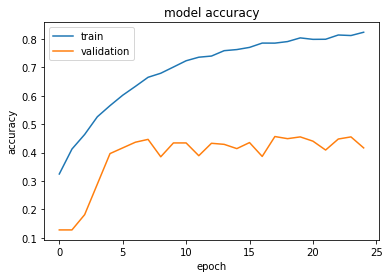

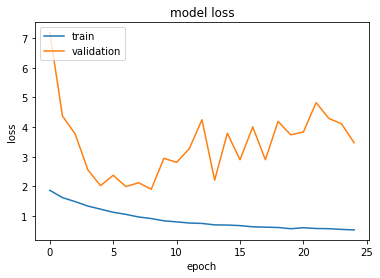

In [343]:
show_summary_stats(fma_mels_ffnn_history)

In [303]:
npzfile = np.load('/content/gdrive/MyDrive/fma_small/test_data.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [304]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1.0000000000003177 1.6821718493756723 1.0606265312779075


In [305]:
X_test = np.log(X_test_raw)

In [344]:
fma_mels_ffnn_model.evaluate(X_test, y_test)

25/25 [==============================] - 0s 9ms/step - loss: 4.5243 - accuracy: 0.3487


[4.524255752563477, 0.3487499952316284]

In [345]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [346]:
## Generate the classification report 
y_validReport = to_categorical(y_valid)
y_true = np.argmax(y_validReport, axis=1)
y_pred = fma_mels_ffnn_model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.40      0.27      0.32       100
 Experimental       0.52      0.42      0.46       100
         Folk       0.41      0.76      0.53       100
      Hip-Hop       0.53      0.41      0.46       100
 Instrumental       0.35      0.28      0.31       100
International       0.33      0.63      0.43       100
          Pop       0.15      0.06      0.09       100
         Rock       0.68      0.50      0.57       100

     accuracy                           0.42       800
    macro avg       0.42      0.42      0.40       800
 weighted avg       0.42      0.42      0.40       800



# 2. Evaluate Fully Connected Neural Network using MFCCs

## On GTZAN Dataset

### 1 segment MFCCs for GTZAN

#### Code to prepare MFCCs for GTZAN dataset

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"
JSON_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-1s.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512
def save_mfcc(dataset_path, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=1):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)

#### Load the MFCCs for GTZAN dataset, build, train and evaluate the model

In [ ]:
GTZAN_DATA_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan-1s.json" 

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [ ]:
# load data
X, y = load_data(GTZAN_DATA_PATH)

In [ ]:
print(X.shape)
print(y.shape)

(999, 1292, 20)
(999,)


In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
X_train.shape

(561, 1292, 20)

In [ ]:
X_validation.shape

(188, 1292, 20)

In [ ]:
X_test.shape

(250, 1292, 20)

In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add 4 dense layers
    model.add(keras.layers.Dense(256,  activation='relu', kernel_initializer='glorot_uniform', input_shape=input_shape))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(128,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(64,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(16,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
gtzan_mfcc_1s_model = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.00075)
gtzan_mfcc_1s_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mfcc_1s_history = gtzan_mfcc_1s_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=1,
                                          batch_size=128, epochs=75 )

Epoch 1/75
5/5 [==============================] - 4s 228ms/step - loss: 2.4026 - accuracy: 0.1830 - val_loss: 52.7876 - val_accuracy: 0.1862
Epoch 2/75
5/5 [==============================] - 0s 62ms/step - loss: 1.9437 - accuracy: 0.2766 - val_loss: 17.6810 - val_accuracy: 0.1702
Epoch 3/75
5/5 [==============================] - 0s 62ms/step - loss: 1.7690 - accuracy: 0.3442 - val_loss: 14.9070 - val_accuracy: 0.1702
Epoch 4/75
5/5 [==============================] - 0s 62ms/step - loss: 1.6132 - accuracy: 0.4445 - val_loss: 8.0739 - val_accuracy: 0.1968
Epoch 5/75
5/5 [==============================] - 0s 62ms/step - loss: 1.5312 - accuracy: 0.4859 - val_loss: 7.2842 - val_accuracy: 0.1649
Epoch 6/75
5/5 [==============================] - 0s 62ms/step - loss: 1.4618 - accuracy: 0.5204 - val_loss: 4.3334 - val_accuracy: 0.2234
Epoch 7/75
5/5 [==============================] - 0s 63ms/step - loss: 1.3775 - accuracy: 0.5464 - val_loss: 4.9750 - val_accuracy: 0.1915
Epoch 8/75
5/5 [=======

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


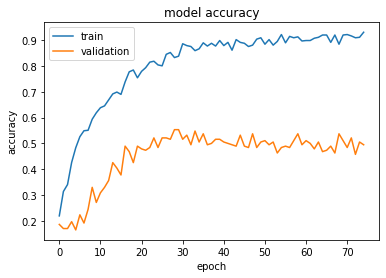

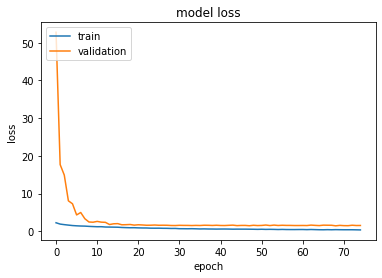

In [ ]:
show_summary_stats(gtzan_mfcc_1s_history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mfcc_1s_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

8/8 - 0s - loss: 1.5028 - accuracy: 0.5240

Test accuracy: 0.5239999890327454


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mfcc_1s_model.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(188,) (188,)
              precision    recall  f1-score   support

       blues       0.47      0.37      0.41        19
   classical       0.79      0.79      0.79        19
     country       0.44      0.37      0.40        19
       disco       0.29      0.11      0.15        19
      hiphop       0.58      0.39      0.47        18
        jazz       0.29      0.79      0.43        19
       metal       0.78      0.95      0.86        19
         pop       0.64      0.84      0.73        19
      reggae       0.33      0.11      0.17        18
        rock       0.29      0.21      0.24        19

    accuracy                           0.49       188
   macro avg       0.49      0.49      0.46       188
weighted avg       0.49      0.49      0.47       188



### 5 segments MFCCs for GTZAN

#### Code to prepare MFCCs for GTZAN dataset

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/gdrive/MyDrive/gtzan_genres_data"
JSON_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512
def save_mfcc(dataset_path, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00002.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00002.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00003.wav, segment:5
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:1
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:2
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:3
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:4
/content/gdrive/MyDrive/gtzan_genres_data/country/country.00005.wav, segment:5
/

#### Load the MFCCs for GTZAN dataset, build, train and evaluate the model

In [ ]:
GTZAN_DATA_PATH = "/content/gdrive/MyDrive/gtzan_genres_data/data-gtzan.json" 

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [ ]:
# load data
X, y = load_data(GTZAN_DATA_PATH)

In [ ]:
print(X.shape)
print(y.shape)

(4998, 259, 20)
(4998,)


In [ ]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
X_train.shape

(2811, 259, 20)

In [ ]:
X_validation.shape

(937, 259, 20)

In [ ]:
X_test.shape

(1250, 259, 20)

In [ ]:
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add 4 dense layers
    model.add(keras.layers.Dense(256,  activation='relu', kernel_initializer='glorot_uniform', input_shape=input_shape))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(128,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(64,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(16,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train.shape[1], X_train.shape[2]) 
gtzan_mfcc_model_5s = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.00075)
gtzan_mfcc_model_5s.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
gtzan_mfcc_history_5s = gtzan_mfcc_model_5s.fit(X_train, y_train, validation_data=(X_validation, y_validation), verbose=1,
                                          batch_size=128, epochs=75 )

Epoch 1/75
22/22 [==============================] - 3s 33ms/step - loss: 2.3158 - accuracy: 0.2108 - val_loss: 3.6806 - val_accuracy: 0.2423
Epoch 2/75
22/22 [==============================] - 0s 19ms/step - loss: 1.9137 - accuracy: 0.3216 - val_loss: 2.4246 - val_accuracy: 0.3276
Epoch 3/75
22/22 [==============================] - 0s 18ms/step - loss: 1.7809 - accuracy: 0.3765 - val_loss: 2.1559 - val_accuracy: 0.3607
Epoch 4/75
22/22 [==============================] - 0s 18ms/step - loss: 1.6774 - accuracy: 0.4060 - val_loss: 1.7275 - val_accuracy: 0.4205
Epoch 5/75
22/22 [==============================] - 0s 18ms/step - loss: 1.6093 - accuracy: 0.4476 - val_loss: 1.5332 - val_accuracy: 0.4728
Epoch 6/75
22/22 [==============================] - 0s 18ms/step - loss: 1.5711 - accuracy: 0.4623 - val_loss: 1.4167 - val_accuracy: 0.5112
Epoch 7/75
22/22 [==============================] - 0s 18ms/step - loss: 1.4884 - accuracy: 0.4861 - val_loss: 1.2897 - val_accuracy: 0.5784
Epoch 8/75
22

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


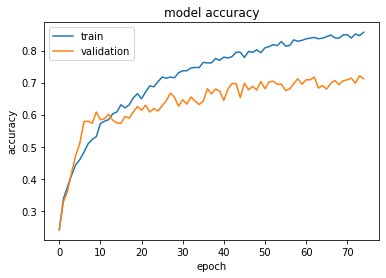

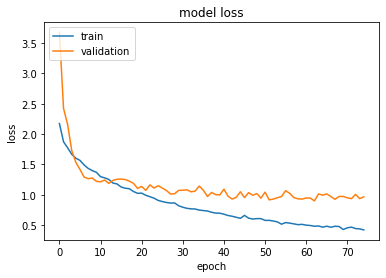

In [ ]:
show_summary_stats(gtzan_mfcc_history_5s)

In [ ]:
# evaluate model on test set
test_loss, test_acc = gtzan_mfcc_model_5s.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

40/40 - 0s - loss: 0.9692 - accuracy: 0.7096

Test accuracy: 0.7095999717712402


In [ ]:
# genres dict
gtzan_genre_dict = {0:'blues', 1:'classical', 2:'country', 3:'disco',4:'hiphop',5:'jazz',6:'metal',7:'pop',8:'reggae',9:'rock'}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation)
y_true = np.argmax(y_validReport, axis=1)
y_pred = gtzan_mfcc_model_5s.predict(X_validation)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = gtzan_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(937,) (937,)
              precision    recall  f1-score   support

       blues       0.58      0.83      0.68        94
   classical       0.68      0.96      0.80        94
     country       0.75      0.69      0.72        93
       disco       0.75      0.43      0.54        94
      hiphop       0.73      0.56      0.63        93
        jazz       0.95      0.80      0.87        94
       metal       0.79      0.91      0.85        94
         pop       0.90      0.74      0.81        94
      reggae       0.64      0.71      0.68        94
        rock       0.49      0.48      0.49        93

    accuracy                           0.71       937
   macro avg       0.73      0.71      0.71       937
weighted avg       0.73      0.71      0.71       937



## On FMA Dataset

### Code to prepare MFCCs for FMA dataset


In [ ]:
## Free Music Archive(FMA) dataset details
FMA_Audio_path="/content/gdrive/MyDrive/fma_small"
FMA_Json_data = "/content/gdrive/MyDrive/fma_small/data-fma.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to get a track path given data directory and track_id
def get_audio_path(audio_dir, track_id):
    # print("type of audio dir: ",type(track_id))
    # print("track id: ",track_id)
    tid_str = '{:06d}'.format(int(track_id))
    # return os.path.join(audio_dir, track_id[:3], track_id + '.mp3')
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [ ]:
## Read the tracks details from csv to a dataframe
df = pd.read_csv("/content/gdrive/MyDrive/fma_small/tracks_with_required_columns.csv", index_col=0, header=[0, 1])

In [ ]:
df.head()

set            track
             split subset genre_top
track_id                           
2         training  small   Hip-Hop
5         training  small   Hip-Hop
10        training  small       Pop
140       training  small      Folk
141       training  small      Folk

In [ ]:
df['track_id'] = df.index
df.head()

set            track track_id
             split subset genre_top         
track_id                                    
2         training  small   Hip-Hop        2
5         training  small   Hip-Hop        5
10        training  small       Pop       10
140       training  small      Folk      140
141       training  small      Folk      141

In [ ]:
print(df.shape)
df[('track', 'genre_top')].unique()

(8000, 4)


array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [ ]:
## Creating a dictionary of labels
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [ ]:
## Method to save FMA MFCC into data.json
## hop_length=512
def save_mfcc(dataset_path, json_path, dict_genres, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=5):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    for i in dict_genres.keys():
      data["mapping"].append(i)
    count = 0
    for index, row in df.iterrows():
        with warnings.catch_warnings():
            try:
                warnings.simplefilter("ignore")
                count += 1
                track_id = int(row['track_id'])
                genre = str(row[('track', 'genre_top')])
                file_path = get_audio_path(dataset_path, track_id)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(dict_genres.get(genre))
                        print("{}, segment:{}".format(file_path, d+1))
                    # print("data: ",data)
                if count % 100 == 0:
                    print("Currently processing: ", count)
                # break
                
            except:
                print("Couldn't process: ", count)
                continue


    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
now = datetime.now()
save_mfcc(FMA_Audio_path, FMA_Json_data, dict_genres, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=5)
print("Time taken: ", (datetime.now() - now).total_seconds())

### Load the MFCCs for FMA dataset, build, train and evaluate the model

In [ ]:
## Path to MFCC of FMA dataset
FMA_DATA_PATH = "/content/gdrive/MyDrive/fma_small/data-fma.json"

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [ ]:
# load data
X, y = load_data(FMA_DATA_PATH)

In [ ]:
print(X.shape)
print(y.shape)

(15982, 323, 20)
(15982,)


In [ ]:
# get train, validation, test splits
# create train, validation and test split
X_train_fma, X_test_fma, y_train_fma, y_test_fma = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train_fma, X_validation_fma, y_train_fma, y_validation_fma = train_test_split(X_train_fma, y_train_fma, random_state=42, stratify=y_train_fma, test_size=0.25)

In [ ]:
print(X_train_fma.shape)
print(X_validation_fma.shape)
print(X_test_fma.shape)

(8989, 323, 20)
(2997, 323, 20)
(3996, 323, 20)


In [ ]:
# Model
## Create the model of the layers as per the input shape
def build_model(input_shape):

    # create the sequential model
    model = keras.Sequential()

    # add 4 dense layers
    model.add(keras.layers.Dense(323,  activation='relu', kernel_initializer='glorot_uniform', input_shape=input_shape))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(162,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Dense(81,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(32,  activation='relu', kernel_initializer='glorot_uniform'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.BatchNormalization())
    # output layer
    model.add(keras.layers.Dense(8, activation='softmax'))

    return model

In [ ]:
# create network
input_shape = (X_train_fma.shape[1], X_train_fma.shape[2]) 
fma_mfcc_model = build_model(input_shape)

In [ ]:
# compile model
optimiser = keras.optimizers.RMSprop(learning_rate=0.00075)
fma_mfcc_model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
fma_mfcc_history = fma_mfcc_model.fit(X_train_fma, y_train_fma, validation_data=(X_validation_fma, y_validation_fma), verbose=1,
                                          batch_size=256, epochs=35 )

Epoch 1/35
36/36 [==============================] - 3s 35ms/step - loss: 2.1766 - accuracy: 0.2393 - val_loss: 5.5207 - val_accuracy: 0.1828
Epoch 2/35
36/36 [==============================] - 1s 27ms/step - loss: 1.8467 - accuracy: 0.3418 - val_loss: 2.6027 - val_accuracy: 0.2936
Epoch 3/35
36/36 [==============================] - 1s 27ms/step - loss: 1.7692 - accuracy: 0.3607 - val_loss: 2.0079 - val_accuracy: 0.3747
Epoch 4/35
36/36 [==============================] - 1s 27ms/step - loss: 1.6947 - accuracy: 0.3934 - val_loss: 1.8287 - val_accuracy: 0.3874
Epoch 5/35
36/36 [==============================] - 1s 27ms/step - loss: 1.6257 - accuracy: 0.4083 - val_loss: 1.7252 - val_accuracy: 0.3904
Epoch 6/35
36/36 [==============================] - 1s 27ms/step - loss: 1.5919 - accuracy: 0.4220 - val_loss: 1.7432 - val_accuracy: 0.3857
Epoch 7/35
36/36 [==============================] - 1s 27ms/step - loss: 1.5505 - accuracy: 0.4447 - val_loss: 1.8109 - val_accuracy: 0.3854
Epoch 8/35
36

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


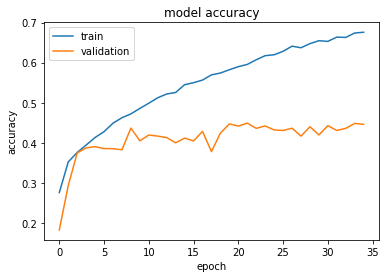

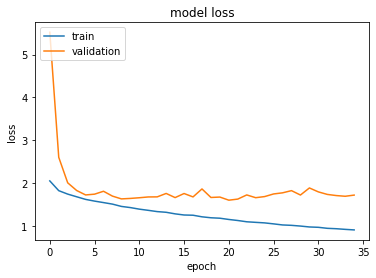

In [ ]:
show_summary_stats(fma_mfcc_history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = fma_mfcc_model.evaluate(X_test_fma, y_test_fma, verbose=2)
print('\nTest accuracy:', test_acc)

125/125 - 0s - loss: 1.7367 - accuracy: 0.4339

Test accuracy: 0.43393394351005554


In [ ]:
genres_dict = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock':7}

In [ ]:
## Generate the classification report 
y_validReport = to_categorical(y_validation_fma)
y_true = np.argmax(y_validReport, axis=1)
y_pred = fma_mfcc_model.predict(X_validation_fma)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = genres_dict.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(2997,) (2997,)
               precision    recall  f1-score   support

   Electronic       0.47      0.48      0.47       375
 Experimental       0.36      0.27      0.31       375
         Folk       0.47      0.65      0.55       375
      Hip-Hop       0.63      0.48      0.55       374
 Instrumental       0.40      0.41      0.41       374
International       0.55      0.39      0.45       375
          Pop       0.26      0.25      0.25       375
         Rock       0.47      0.64      0.54       374

     accuracy                           0.45      2997
    macro avg       0.45      0.45      0.44      2997
 weighted avg       0.45      0.45      0.44      2997



# 3. Results comparison

```markdown
                          GTZAN

Input Type  | Train accuracy | Validation accuracy | Test accuracy |  F1 Score   
------------|----------------|---------------------|---------------|-------------
MFCCs 1s    |     0.9295     |       0.4947        |     0.5239    |    0.47
Mel-Specs 1s|     0.8578     |       0.4150        |     0.4650    |    0.40

                  Improved 5 segments model
Input Type  | Train accuracy | Validation accuracy | Test accuracy |  F1 Score   
------------|----------------|---------------------|---------------|-------------
MFCCs 5s    |     0.8532     |       0.7118        |     0.7095    |    0.71
Mel-Specs 5s|     0.8889     |       0.7353        |     0.7304    |    0.72

```
```markdown
                          FMA
Input Type  | Train accuracy | Validation accuracy | Test accuracy |  F1 Score   
------------|----------------|---------------------|---------------|-------------
MFCCs 1s    |     0.6747     |       0.4461        |     0.4339    |    0.44
Mel-Specs 1s|     0.8312     |       0.4162        |     0.3487    |    0.40

```